In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk

from haversine import haversine # haversine 거리 계산, pip install haversine
from patsy import dmatrix

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import warnings
warnings.filterwarnings("ignore")

/Users/sunwoongkim/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("../../dataset/train.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])

## 1. train data의 기본 정보 탐색 및 전처리

#### 1. train data의 구성
    - shape
    - info
    - describe

#### 2. 기초 전처리
    - datetime parsing
    - distance 계산
    - 클래스가 2개인 카테고리 binary 형태로 변경

In [3]:
print("traing data의 row 수 :{}", 
      "column 수 : {}".format(train.shape[0], train.shape[1]))

traing data의 row 수 :{} column 수 : 1458644


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [5]:
train.describe().round(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [7]:
train["pickup_month"] = train["pickup_datetime"].dt.month
train["dropoff_month"] = train["dropoff_datetime"].dt.month

train["pickup_weekday"] = train["pickup_datetime"].dt.weekday
train["dropoff_weekday"] = train["dropoff_datetime"].dt.weekday

train["pickup_hour"] = train["pickup_datetime"].dt.hour
train["dropoff_hour"] = train["dropoff_datetime"].dt.hour

In [22]:
working_day = [0, 1, 2, 3, 4] # Mon-Fri

train["working_day"] = train["pickup_weekday"].isin(working_day).astype(int)

In [10]:
train["store_and_fwd_flag"] = 1 * (train.store_and_fwd_flag.values == 'Y')

In [11]:
pickup_lat = tuple(train["pickup_latitude"])
pickup_lng = tuple(train["pickup_longitude"])
dropoff_lat = tuple(train["dropoff_latitude"])
dropoff_lng = tuple(train["dropoff_longitude"])

pickup_loc = tuple(zip(pickup_lat, pickup_lng))
dropoff_loc = tuple(zip(dropoff_lat, dropoff_lng))

distance = []
for i in range(len(pickup_loc)):
    distance.append(haversine(pickup_loc[i], dropoff_loc[i]))

train["distance"] = distance
print(len(pickup_loc), len(dropoff_loc), len(distance))

1458644 1458644 1458644


In [23]:
train.shape

(1458644, 19)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 19 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null int64
trip_duration         1458644 non-null int64
pickup_month          1458644 non-null int64
dropoff_month         1458644 non-null int64
pickup_weekday        1458644 non-null int64
dropoff_weekday       1458644 non-null int64
pickup_hour           1458644 non-null int64
dropoff_hour          1458644 non-null int64
distance              1458644 non-null float64
working_day           1458644 non-null int64
dty

In [26]:
train.describe().round(3)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,pickup_hour,dropoff_hour,distance,working_day
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,0.006,959.492,3.517,3.517,3.050,3.054,13.606,13.599,3.441,0.715
std,0.499,1.314,0.071,0.033,0.071,0.036,0.074,5237.432,1.681,1.681,1.954,1.957,6.400,6.484,4.297,0.452
min,1.000,0.000,-121.933,34.360,-121.933,32.181,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,0.000,397.000,2.000,2.000,1.000,1.000,9.000,9.000,1.232,0.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,0.000,662.000,4.000,4.000,3.000,3.000,14.000,14.000,2.094,1.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,0.000,1075.000,5.000,5.000,5.000,5.000,19.000,19.000,3.875,1.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,1.000,3526282.000,6.000,7.000,6.000,6.000,23.000,23.000,1240.909,1.000


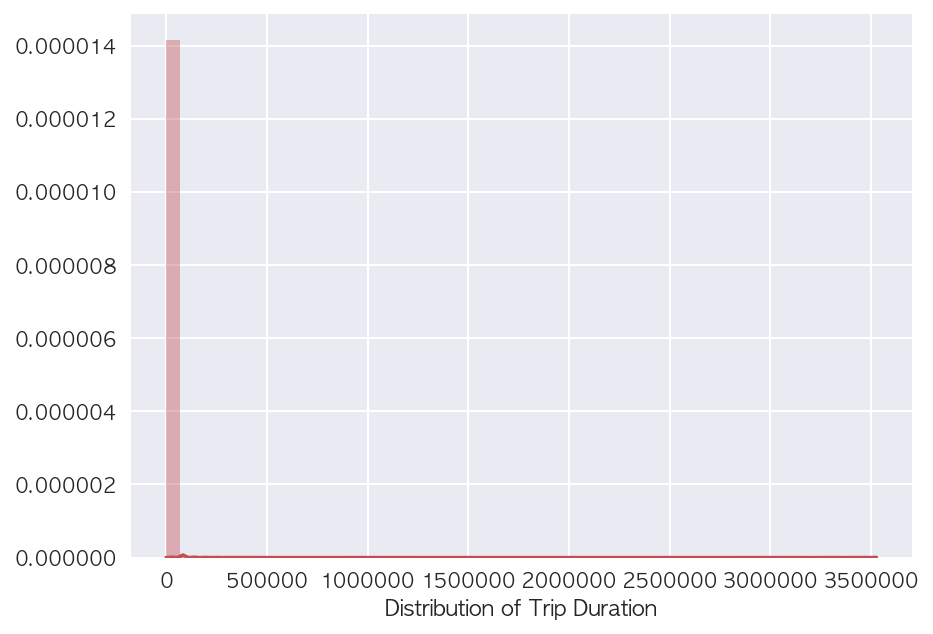

In [21]:
plt.figure(figsize=(7, 5))
sns.distplot(train["trip_duration"], color="r")
plt.xlabel("Distribution of Trip Duration")
plt.show()

In [27]:
# 종속변수/독립변수 분리

X_cols = [col for col in train.columns if col != "trip_duration"]
train_X0 = train[X_cols]
train_y = train[["trip_duration"]]

In [29]:
col_real = ["passenger_count", "distance", "pickup_longitude", 
            "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]

col_cats = [col for col in train.columns if col not in col_real]
# ["pickup_hour", "pickup_weekday", "pickup_month", "dropoff_hour", "dropoff_weekday", "dropoff_month", ]
for col in ["pickup_datetime", "dropoff_datetime"]:
    col_cats.remove(col)

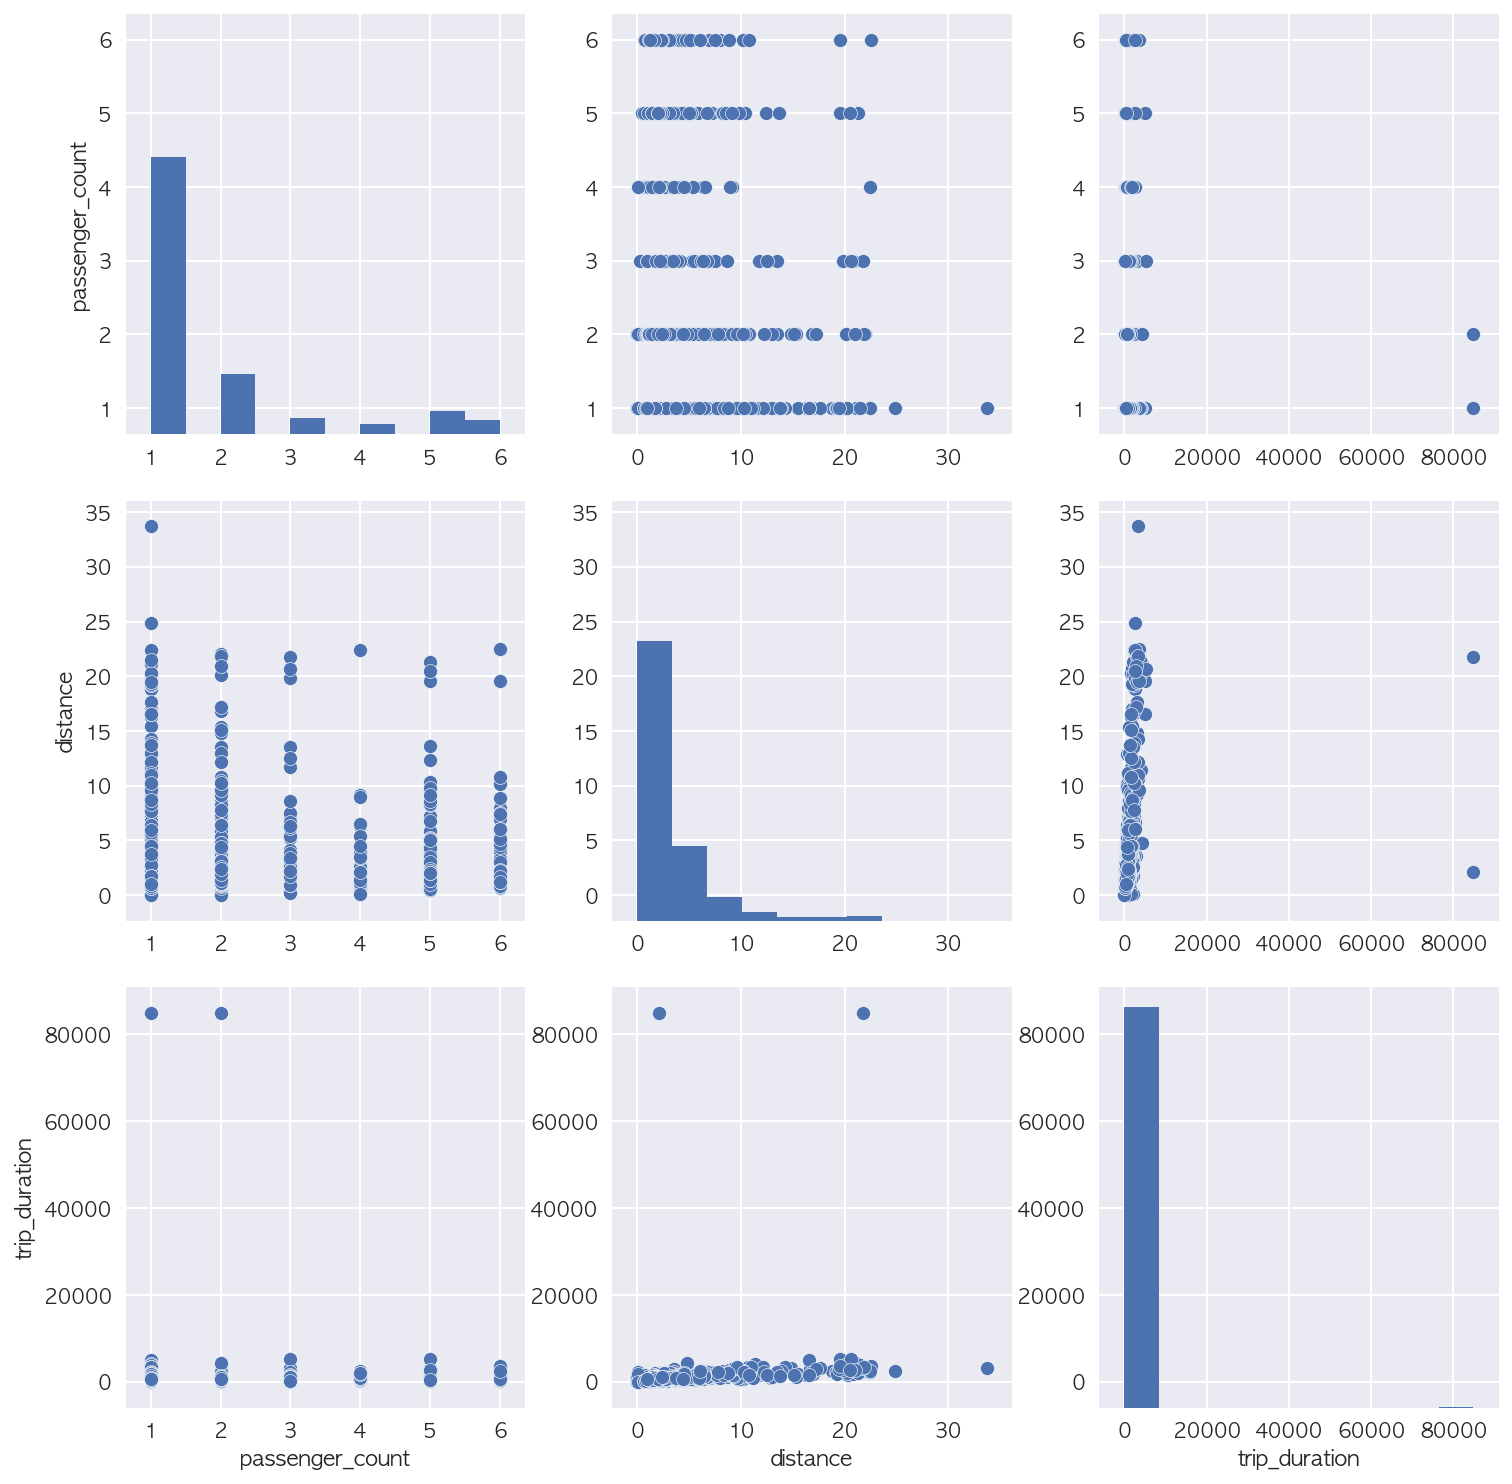

In [57]:
# passenger_count, distance, avg_speed_h

sns.pairplot(pd.concat([train_X0[col_real[:2]], train_y], axis=1)[::1000], size=3.5)
plt.show()

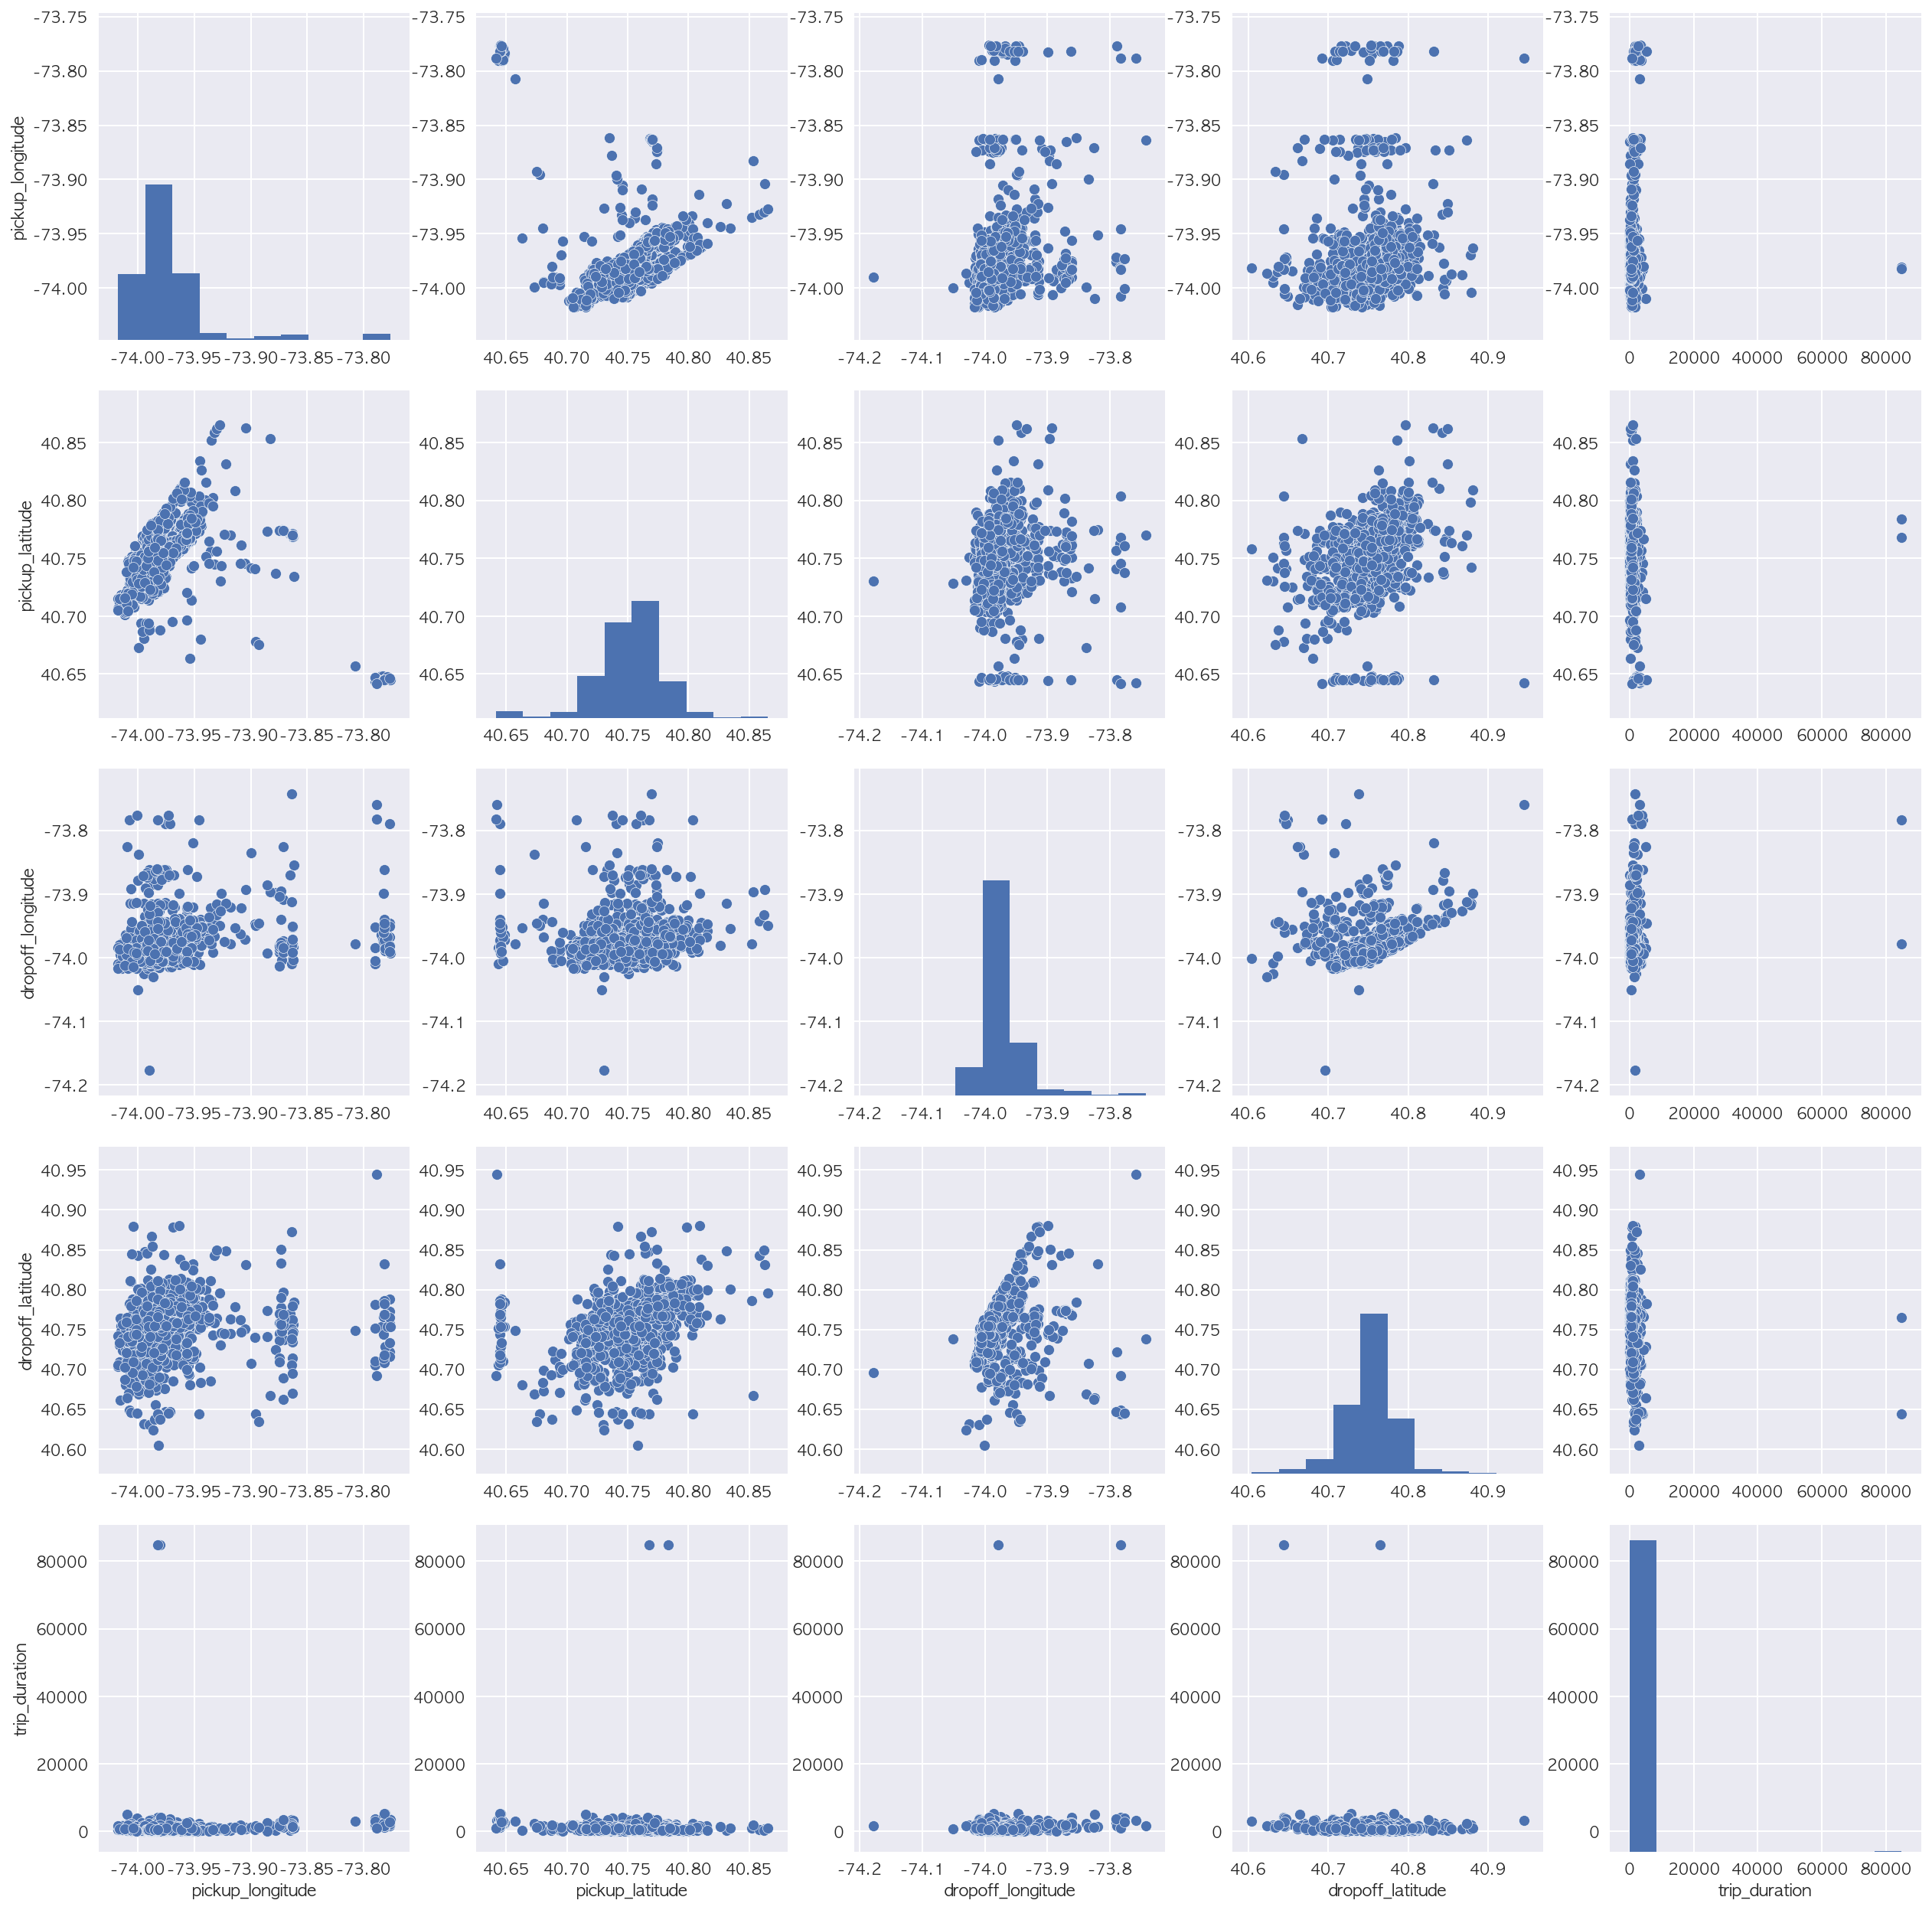

In [58]:
sns.pairplot(pd.concat([train_X0[col_real[2:]], train_y], axis=1)[::1000], size=3.5)
plt.show()